# Multirotor Dynamic Model

$M_b = J \dot{\omega_b} + \omega_b \times (J \omega_b)$

$\dot{\omega_b} = J^{-1}(M_b - \omega_b \times (J \omega_b))$

$F_b = m \dot{v_b} + \omega_b \times (m v_b)$

$\dot{v_b} = F_b/m -  \omega_b \times v_b$

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import control
import collections
import sys
sys.path.insert(0, '../python/pyecca')
import pyecca.lie.so3 as so3
np.set_printoptions(suppress=True, precision=3, linewidth=200)

In [2]:
class NamedSXVect(ca.SX):

    def __init__(self, symbols, names):
        super().__init__(symbols)
        self.names = names
        self.index = {}
        for i in range(len(self.names)):
            self.index[self.names[i]] = i
    
    @classmethod
    def from_string(cls, names):
        names = [name.strip() for name in names.split(',')]
        symbols = ca.vertcat(*[ca.SX.sym(name) for name in names])
        return cls(symbols, names)
            
    def __getitem__(self, key):
        if isinstance(key, int):
            return super().__getitem__(key)
        else:
            return super().__getitem__(self.index[key])

sym = ca.SX.sym('x', 3)
named_sym = NamedSXVect(sym, ['a', 'b', 'c'])
named_sym['a']

SX(x_0)

In [3]:
def quadrotor_model():
    # state space model
    
    #x: state: (position, orientation, velocity (body frame), angular velocity (body frame))
    x = NamedSXVect.from_string('P, Q, R, v_X, v_Y, v_Z, r0, r1, r2, p_N, p_E, p_D, rpm0, rpm1, rpm2, rpm3')
    omega_b = ca.vertcat(x['P'], x['Q'], x['R'])
    v_b = ca.vertcat(x['v_X'], x['v_Y'], x['v_Z'])
    r_nb = ca.vertcat(x['r0'], x['r1'], x['r2'], ca.SX.sym('r3'))
    p_n = ca.vertcat(x['p_N'], x['p_E'], x['p_D'])
    rpm = ca.vertcat(x['rpm0'], x['rpm1'], x['rpm2'], x['rpm3'])

    #u: control
    u = NamedSXVect.from_string('u_roll, u_pitch, u_yaw, u_thrust')

    # p: parameters
    p = NamedSXVect.from_string('l, m, g, Jx, Jy, Jz, Jxz, tau, rho, r, V, kV, CT, CM')

    #y: output
    C_nb = so3.Dcm.from_mrp(r_nb)
    v_n = ca.mtimes(C_nb, v_b)
    y = NamedSXVect(ca.vertcat(x, v_n), x.names + ['v_N', 'v_E', 'v_D'])

    J = ca.SX.zeros(3, 3)
    J[0, 0] = p['Jx']
    J[1, 1] = p['Jy']
    J[2, 2] = p['Jz']
    J[0, 2] = J[2, 0] = p['Jxz']

    # forces and moments
    arm_angles_deg = [45, -135, -45, 135]
    motor_dirs = [-1, -1, 1, 1]
    mix_matrix =ca.DM([
        [-1, 1, 1, -1], # roll
        [1, -1, 1, -1], # pitch
        [1, 1, -1, -1], # yaw
        [1, 1, 1, 1] # thrust
    ])
    u_rpm = ca.mtimes(ca.inv(mix_matrix), u)
    F_b = ca.mtimes(C_nb.T, ca.vertcat(0, 0, p['m']*p['g']))
    M_b = ca.SX.zeros(3)
    for theta_deg, rpm_i, motor_dir in zip(arm_angles_deg, rpm, motor_dirs):
        theta = theta_deg*ca.pi/180
        omega = rpm_i*p['V']*p['kV']*(2*ca.pi/60)
        q = p['rho']*(omega*p['r'])**2/2
        s = ca.pi*p['r']**2
        arm_b = ca.vertcat(ca.cos(theta), ca.sin(theta), 0)
        Fi_b = ca.vertcat(0, 0, -p['CT']*q*s)
        Mi_b = ca.vertcat(0, 0, -motor_dir*p['CM']*q*s) + ca.cross(arm_b, Fi_b)
        F_b += Fi_b
        M_b += Mi_b

    x_dot = ca.vertcat(
        ca.mtimes(ca.inv(J), M_b - ca.cross(omega_b, ca.mtimes(J, omega_b))),
        F_b/p['m'] - ca.cross(omega_b, v_b),
        so3.Mrp.kinematics(r_nb, omega_b)[:3],
        ca.mtimes(C_nb, v_b),
        (u_rpm - rpm)/p['tau']
    )
    
    rhs = ca.Function('rhs', [x, u, p], [x_dot])
    
    return {
        'x': x,
        'y': y,
        'x_dot': x_dot,
        'u': u,
        'p': p,
        'rhs': rhs
    }

def trim_hover(model):
    # motor time constant 0.015 s, https://flyingmachinearena.org/wp-content/publications/2014/mueIEEE14.pdf
    p0 = ca.vertcat(1, 1, 9.8, 1, 1, 1, 0.1, 0.015, 1.225, 0.1, 11.1, 1550, 1e-3, 1e-4)

    # TODO trim
    u0 = ca.vertcat(1000, 1000, 1000, 1000)
    x0 = ca.vertcat(0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0, 0, u0)
    return x0, u0, p0

def linearize(model, x0, u0, p0):

    # linearization
    A = ca.jacobian(model['x_dot'], model['x'])
    B = ca.jacobian(model['x_dot'], model['u'])
    C = ca.jacobian(model['y'], model['x'])
    D = ca.jacobian(model['y'], model['u'])
    f_ss = ca.Function('ss', [model['x'], model['u'], model['p']], [A, B, C, D])
    
    A0, B0, C0, D0 = f_ss(x0, u0, p0)

    sys = control.ss(A0, B0, C0, D0)
    return sys

In [4]:
model = quadrotor_model()
x0, u0, p0 = trim_hover(model)
sys = linearize(model, x0, u0, p0)

# Body Roll Rate Control


        5.949e+04
-------------------------
s^2 + 66.67 s + 5.515e-12

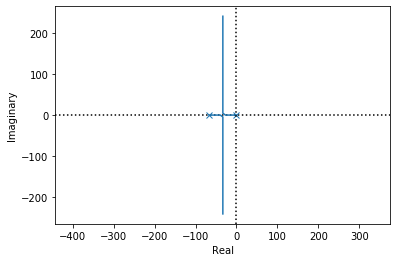

In [5]:
G_roll_rate = control.ss2tf(sys[model['y'].index['P'], model['u'].index['u_roll']])
control.rlocus(G_roll_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_roll_rate

(inf, 61.44275238117672, nan, 72.82566417153188)


<Figure size 432x288 with 0 Axes>

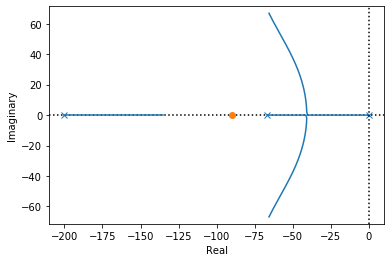

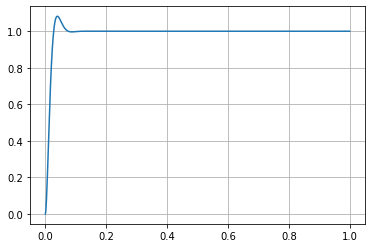

In [6]:
s = control.tf([1, 0], [0, 1])
H_roll_rate = 0.1*(s/90+1)/(s/200 + 1)
Go_roll_rate = G_roll_rate*H_roll_rate
print(control.margin(Go_roll_rate))

plt.figure()
control.rlocus(Go_roll_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_roll_rate = control.feedback(Go_roll_rate)

plt.figure()
t, y = control.step_response(Gc_roll_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()



# Body Roll Control

(4.868953480974533, 68.7936060131583, 108.17677828605653, 30.80793431496759)


<Figure size 432x288 with 0 Axes>

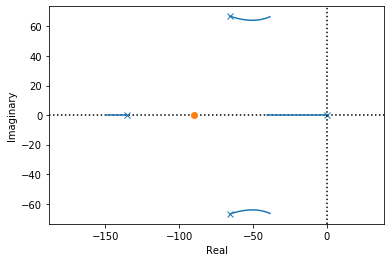

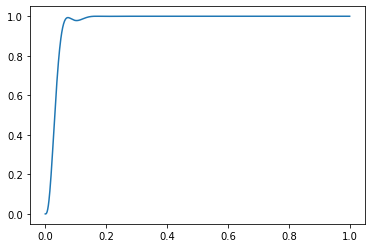

In [7]:
H_roll = 30
G_roll = Gc_roll_rate/s
Go_roll = H_roll*G_roll
Gc_roll = control.feedback(Go_roll)
print(control.margin(Go_roll))

plt.figure()
control.rlocus(Go_roll, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

plt.figure()
t, y = control.step_response(Gc_roll, np.linspace(0, 1, 1000))
plt.plot(t, y)

# Body Yaw Rate Control


          8413
-------------------------
s^2 + 66.67 s + 4.153e-12

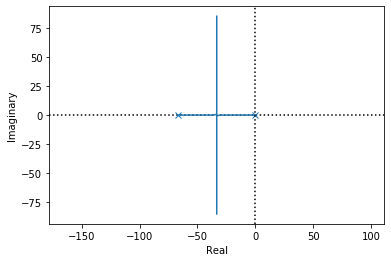

In [8]:
G_yaw_rate = control.ss2tf(sys[model['y'].index['R'], model['u'].index['u_yaw']])
control.rlocus(G_yaw_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_yaw_rate

(inf, 57.45311890021898, nan, 42.54807839872257)


<Figure size 432x288 with 0 Axes>

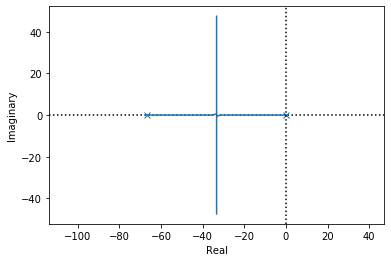

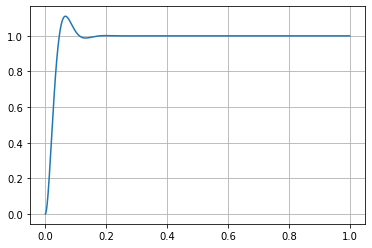

In [9]:
H_yaw_rate = 0.4
Go_yaw_rate = G_yaw_rate*H_yaw_rate
print(control.margin(Go_yaw_rate))

plt.figure()
control.rlocus(Go_yaw_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_yaw_rate = control.feedback(Go_yaw_rate)

plt.figure()
t, y = control.step_response(Gc_yaw_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()

# Body Yaw Control

(4.444444444444475, 71.91755280227125, 58.00868819458393, 15.329741102247425)


<Figure size 432x288 with 0 Axes>

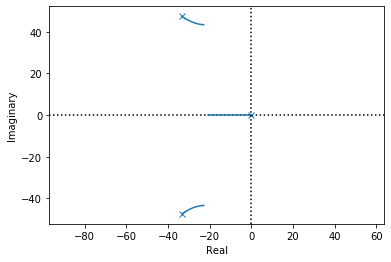

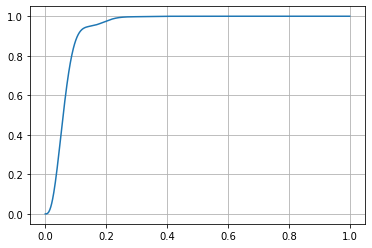

In [10]:
H_yaw = 15
G_yaw = Gc_yaw_rate/s
Go_yaw = G_yaw*H_yaw
print(control.margin(Go_yaw))

plt.figure()
control.rlocus(Go_yaw, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_yaw = control.feedback(Go_yaw)

plt.figure()
t, y = control.step_response(Gc_yaw, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()

# Climb Rate Control


  8.328e+04
-------------
s^2 + 66.67 s

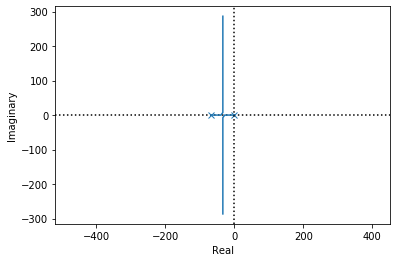

In [11]:
G_climb_rate = control.ss2tf(-sys[model['y'].index['v_D'], model['u'].index['u_thrust']])
control.rlocus(G_climb_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_climb_rate

(inf, 53.14209069059456, nan, 49.97820800873587)


<Figure size 432x288 with 0 Axes>

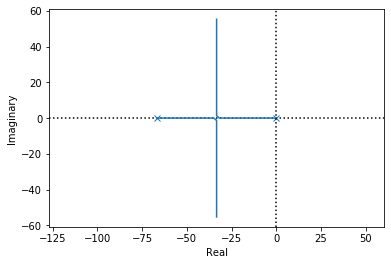

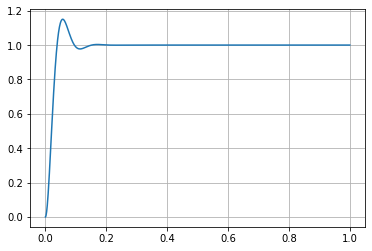

In [12]:
H_climb_rate = 0.05
Go_climb_rate = G_climb_rate*H_climb_rate
print(control.margin(Go_climb_rate))

plt.figure()
control.rlocus(Go_climb_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_climb_rate = control.feedback(Go_climb_rate)

plt.figure()
t, y = control.step_response(Gc_climb_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()

In [13]:
np.linalg.matrix_rank(control.ctrb(sys.A, sys.B))

4

In [14]:
np.linalg.matrix_rank(control.ctrb(sys.A, sys.B), 1e6)

16

In [15]:
u, s, vh = np.linalg.svd(control.ctrb(sys.A, sys.B))
u

matrix([[ 0.   ,  0.994, -0.   , -0.1  ,  0.036, -0.011,  0.02 , -0.004, -0.007, -0.014, -0.004, -0.001,  0.   ,  0.   , -0.   , -0.   ],
        [ 0.   ,  0.   ,  0.999, -0.   ,  0.003, -0.01 ,  0.015, -0.003,  0.016,  0.029,  0.001, -0.002, -0.002, -0.003,  0.   ,  0.   ],
        [ 0.   , -0.103,  0.   , -0.961,  0.233, -0.053, -0.093,  0.026,  0.009,  0.007,  0.   ,  0.   ,  0.   ,  0.001, -0.   , -0.   ],
        [-0.   , -0.   , -0.002,  0.   , -0.002, -0.001,  0.   ,  0.008,  0.219, -0.121,  0.036, -0.479,  0.465, -0.698,  0.062,  0.005],
        [ 0.   ,  0.002, -0.   , -0.   , -0.001,  0.001, -0.029,  0.068, -0.8  ,  0.485,  0.019, -0.057,  0.333, -0.072,  0.005, -0.   ],
        [ 1.   , -0.   , -0.   ,  0.   ,  0.008,  0.028,  0.006,  0.003,  0.003,  0.005,  0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   ],
        [-0.   , -0.004,  0.   ,  0.   ,  0.001, -0.   ,  0.   , -0.   , -0.008,  0.023, -0.995, -0.098, -0.013,  0.001, -0.004,  0.004],
        [-0.   , -0.   , -0.004,  

In [16]:
model['x'].index

{'P': 0,
 'Q': 1,
 'R': 2,
 'v_X': 3,
 'v_Y': 4,
 'v_Z': 5,
 'r0': 6,
 'r1': 7,
 'r2': 8,
 'p_N': 9,
 'p_E': 10,
 'p_D': 11,
 'rpm0': 12,
 'rpm1': 13,
 'rpm2': 14,
 'rpm3': 15}

In [17]:
K, S, E = control.lqr(sys.A, sys.B, np.eye(16), np.eye(4))
K

array([[ 1.03 , -0.   , -0.069, -0.   ,  1.447,  0.   , 21.595,  0.   , -0.069, -0.   ,  0.998, -0.   , -4.466,  4.302,  4.466, -4.302],
       [ 0.   ,  1.032,  0.   , -1.451,  0.   ,  0.   ,  0.   , 21.647,  0.   , -1.   ,  0.   , -0.   ,  4.348, -4.348,  4.348, -4.348],
       [ 0.078,  0.   ,  1.002, -0.   ,  0.101,  0.   ,  1.559,  0.   ,  0.998, -0.   ,  0.069,  0.   ,  1.32 ,  1.155, -1.32 , -1.155],
       [-0.   , -0.   , -0.   ,  0.   ,  0.   , -1.005,  0.   , -0.   ,  0.   ,  0.   ,  0.   , -1.   ,  5.238,  5.238,  5.238,  5.238]])